In [1]:
pip install ultralytics "numpy<2"

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 22.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

# Title & Introduction
Title: Semi-Supervised and Self-Supervised Learning for Sign Language Detection
Objective: Improve object detection performance on a sign language dataset using semi-supervised (pseudo-labeling) and self-supervised (SimCLR / MAE) methods.
Baseline: Assignment 1 YOLOv12 model trained on fully labeled dataset.

# Dataset Description
python import matplotlib.pyplot as plt import glob from PIL import Image

In [2]:
import os
import glob
import torch
import numpy as np
from ultralytics import YOLO

print(f"✅ Current NumPy version: {np.__version__}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Current NumPy version: 1.26.4


In [3]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import random 
import shutil
import albumentations as A
import yaml
from ultralytics import YOLO 
import json
from pathlib import Path
from tqdm import tqdm
import shutil

# Paths
data_dir = '/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split'



In [4]:
#view classes 
with open("/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)

print("Classes:", data_yaml["names"])

Classes: ['yes', 'no', 'hello', 'iloveyou', 'thankyou']


In [5]:
#data splitting count
train_path =  "/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/train"
val_path = "/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/val"
test_path = "/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test"

print("Train images:", len(os.listdir(train_path)))
print("Validation images:", len(os.listdir(val_path)))
print("Test images:", len(os.listdir(test_path)))

Train images: 87
Validation images: 25
Test images: 13


# Show sample images
train_imgs = glob.glob(f"{data_dir}/images/train/.jpg") val_imgs = glob.glob(f"{data_dir}/images/val/.jpg") test_imgs = glob.glob(f"{data_dir}/images/test/*.jpg")
plt.figure(figsize=(12,4)) for i, img_path in enumerate(train_imgs[:5]): img = Image.open(img_path) plt.subplot(1,5,i+1) plt.imshow(img) plt.axis('off') plt.suptitle("Sample Training Images") plt.show()

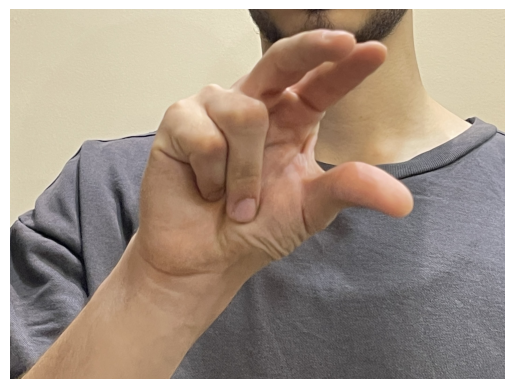

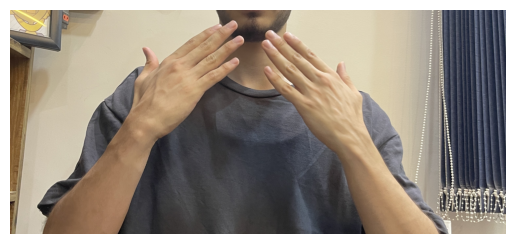

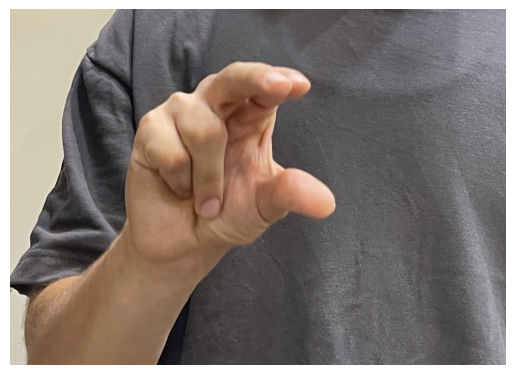

In [7]:
#samples of the data
train_imgs = glob(train_path+'/*.JPG')


for i in random.sample(train_imgs, 3):
    img = cv2.imread(i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [8]:
#copying data to working directory so we could use it

# Paths
input_dir = "/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split"
work_dir = "/kaggle/working/dataset_split"

# Copy dataset to working directory if not already copied
if not os.path.exists(work_dir):
    shutil.copytree(input_dir, work_dir)
shutil.copy(
    "/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/data.yaml",
    "/kaggle/working/dataset_split/data.yaml"
)


print("✅ Dataset copied to working directory:", work_dir)

✅ Dataset copied to working directory: /kaggle/working/dataset_split


# Augmentation dataset

In [9]:
#applying augmentation as the dataset is small so we could increase model efficiency
#config
train_images_dir = os.path.join(work_dir, "images/train")
train_labels_dir = os.path.join(work_dir, "labels/train")
num_augments = 3  # how many augmented copies per image

# Define augmentations (safe for hand signs)
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

# ======================
# AUGMENTATION LOOP
# ======================
for img_file in os.listdir(train_images_dir):
    if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    label_file = os.path.splitext(img_file)[0] + ".txt"
    img_path = os.path.join(train_images_dir, img_file)
    label_path = os.path.join(train_labels_dir, label_file)

    # Read image
    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    # Read labels
    bboxes = []
    class_labels = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            bboxes.append([x, y, bw, bh])
            class_labels.append(int(cls))

    # Apply augmentations multiple times
    for i in range(num_augments):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        # Save augmented image
        aug_img_name = os.path.splitext(img_file)[0] + f"_aug{i}.jpg"
        aug_lbl_name = os.path.splitext(label_file)[0] + f"_aug{i}.txt"

        cv2.imwrite(os.path.join(train_images_dir, aug_img_name), aug_img)

        # Save augmented labels
        with open(os.path.join(train_labels_dir, aug_lbl_name), "w") as f:
            for cls, (x, y, bw, bh) in zip(aug_labels, aug_bboxes):
                f.write(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

print("✅ Augmentation finished! New images and labels added in train/")

✅ Augmentation finished! New images and labels added in train/


In [11]:
#adding yaml file to the working directory 
yaml_path = "/kaggle/working/dataset_split/data.yaml"

with open(yaml_path, "w") as f:
    f.write(
        "train: /kaggle/working/dataset_split/images/train\n"
        "val: /kaggle/working/dataset_split/images/val\n"
        "test: /kaggle/working/dataset_split/images/test\n\n"
        "nc: 5\n"
        "names: ['yes', 'no', 'hello', 'iloveyou', 'thankyou']\n"
    )

# Best Model : Yolov12 model

In [12]:
import os
import glob
import torch
import numpy as np
from ultralytics import YOLO

print(f"✅ Current NumPy version: {np.__version__}")


#  Find Data
yaml_files = glob.glob('/kaggle/working/dataset_split/data.yaml', recursive=True)
dataset_yaml = yaml_files[0] if yaml_files else "data.yaml"

#  Train
model = YOLO('yolo12n.pt') 

print(f"🚀 Starting Training on {dataset_yaml}...")

model.train(
    data=dataset_yaml,
    epochs=20,
    imgsz=640,
    batch=16,
    project='assignment2_runs',
    name='baseline_yolo12',
    seed=42,
    exist_ok=True,
    
    # SAFETY SETTINGS
    amp=False,    # Prevents OpenCV crash
    workers=0     # Prevents Memory Freeze crash
)

✅ Current NumPy version: 1.26.4
🚀 Starting Training on /kaggle/working/dataset_split/data.yaml...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset_split/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_yolo12, nbs=64, nm

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         25         31      0.983          1      0.995      0.719
                   yes          5          5      0.982          1      0.995      0.671
                    no          5          5      0.992          1      0.995      0.631
                 hello          5          5      0.976          1      0.995      0.816
              iloveyou          4          4      0.971          1      0.995      0.821
              thankyou          6         12      0.993          1      0.995      0.657
Speed: 1.4ms preprocess, 207.3ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to /kaggle/working/assignment2_runs/baseline_yolo12


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba7b4141d10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

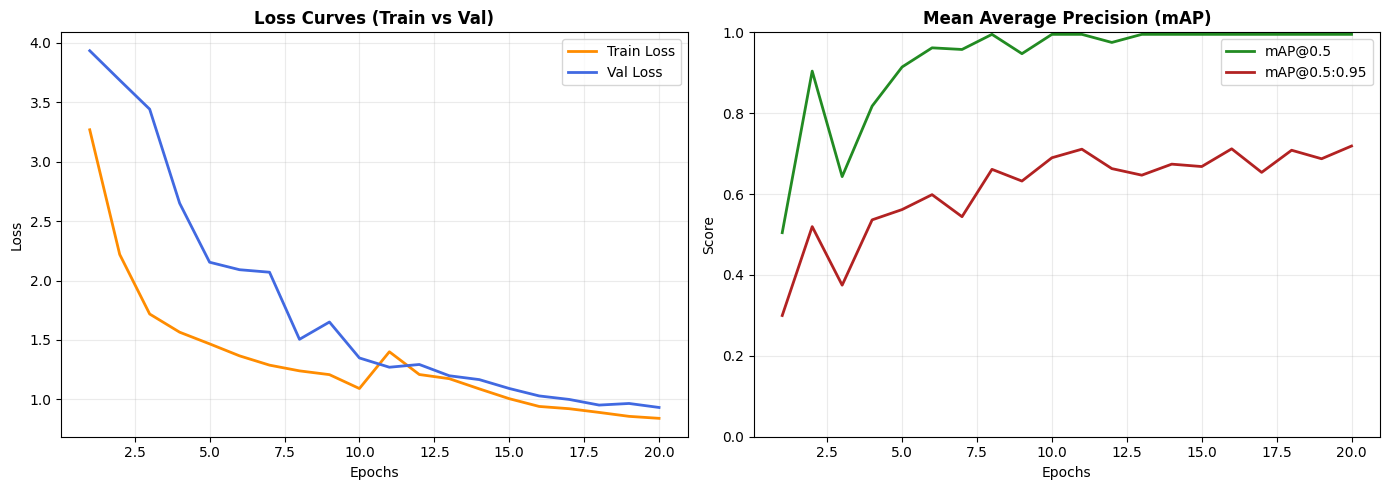

✅ Final v12 mAP@50: 0.995


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Locate the Results File
# Adjust this path if your folder name is different (e.g., 'baseline_model')
results_path = 'assignment2_runs/baseline_yolo12/results.csv'

if os.path.exists(results_path):
    # Read CSV and clean column names (removes extra spaces from YOLO format)
    results = pd.read_csv(results_path)
    results.columns = [c.strip() for c in results.columns]

    # 2. Setup Figure (2 Boxes Side-by-Side)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- BOX 1: LOSS CURVES ---
    # We plot Box Loss and Class Loss. 
    # Solid Lines = Training | Dashed Lines = Validation
    epochs = results['epoch']
    
    # Train Losses
    ax[0].plot(epochs, results['train/cls_loss'], label='Train Loss', color='darkorange',linewidth=2)
    
    # Val Losses (Dashed)
    ax[0].plot(epochs, results['val/cls_loss'], label='Val Loss', color='royalblue', linewidth=2)
    
    ax[0].set_title('Loss Curves (Train vs Val)', fontsize=12, fontweight='bold')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.25)

    # --- BOX 2: mAP METRICS ---
    # We plot mAP@50 and mAP@50-95
    ax[1].plot(epochs, results['metrics/mAP50(B)'], label='mAP@0.5', color='forestgreen', linewidth=2)
    ax[1].plot(epochs, results['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='firebrick', linewidth=2)
    
    ax[1].set_title('Mean Average Precision (mAP)', fontsize=12, fontweight='bold')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Score')
    ax[1].set_ylim(0, 1.0) # Set range from 0 to 1
    ax[1].legend()
    ax[1].grid(True, alpha=0.25)

    # 3. Save and Show
    plt.tight_layout()
    plt.savefig('loss_and_map_visualization.png', dpi=300)
    plt.show()
    print(f"✅ Final v12 mAP@50: {results['metrics/mAP50(B)'].iloc[-1]:.3f}")

# SEMI-SUPERVISED LEARNING (Pseudo-Labeling)

In [14]:
# ============================================================
# SEMI-SUPERVISED LEARNING (Pseudo-Labeling) - FINAL VERSION
# For dataset: sign-language-detection-dataset-5-classes
# ============================================================

import os
import glob
import yaml
from ultralytics import YOLO

print("👨‍🏫 STARTING TASK 2: SEMI-SUPERVISED LEARNING (SSL)")


# ============================================================
# 1) Locate data.yaml
# ============================================================

yaml_files = glob.glob('/kaggle/working/dataset_split/data.yaml', recursive=True)
if not yaml_files:
    raise FileNotFoundError("❌ data.yaml not found inside /kaggle/input")

dataset_yaml = yaml_files[0]
print(f"📌 Found data.yaml: {dataset_yaml}")


# ============================================================
# 2) FIXED — Correct test images path (based on your structure)
# ============================================================

test_images_path = (
    "/kaggle/input/sign-language-detection-dataset-5-classes/"
    "Sign Language Detection/dataset_split/images/test"
)

print(f"📂 Unlabeled Data Source (Absolute): {test_images_path}")

if not os.path.exists(test_images_path):
    raise FileNotFoundError(
        f"❌ Test images not found at: {test_images_path}\n"
        "Your dataset folder structure may be different."
    )


# ============================================================
# 3) Load Teacher Model
# ============================================================

teacher_path = "assignment2_runs/baseline_yolo12/weights/best.pt"

if not os.path.exists(teacher_path):
    raise FileNotFoundError(f"❌ Teacher model not found at: {teacher_path}")

teacher = YOLO(teacher_path)
print(f"✅ Teacher model loaded from: {teacher_path}")


# ============================================================
# 4) Generate Pseudo Labels
# ============================================================

ssl_output_dir = "/kaggle/working/ssl_data"

print("🤖 Teacher generating pseudo-labels...")

teacher.predict(
    source=test_images_path,
    conf=0.4,
    iou=0.6,
    save_txt=True,
    save_conf=False,
    project=ssl_output_dir,
    name="preds",
    exist_ok=True
)

print(f"✅ Pseudo-labels saved at: {ssl_output_dir}/preds/labels")


# ============================================================
# 5) Train Student Model
# ============================================================

print("🎓 Training Student Model...")

# Fresh student model (make sure yolo12n.pt exists)
student = YOLO("yolo12n.pt")

results_student = student.train(
    data=dataset_yaml,
    epochs=20,
    imgsz=640,
    batch=16,
    project="assignment2_runs",
    name="ssl_student_model",
    seed=42,
    exist_ok=True,
    amp=False,
    workers=0,
    dropout=0.1
)

print("🎉 SSL Step Complete.")
print(f"📊 Student mAP@50: {results_student.box.map50:.3f}")

👨‍🏫 STARTING TASK 2: SEMI-SUPERVISED LEARNING (SSL)
📌 Found data.yaml: /kaggle/working/dataset_split/data.yaml
📂 Unlabeled Data Source (Absolute): /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test
✅ Teacher model loaded from: assignment2_runs/baseline_yolo12/weights/best.pt
🤖 Teacher generating pseudo-labels...

image 1/13 /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7282.JPG: 576x640 1 yes, 209.4ms
image 2/13 /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7285.JPG: 448x640 1 yes, 178.6ms
image 3/13 /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7288.JPG: 512x640 1 yes, 204.3ms
image 4/13 /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7306.JPG: 640x512 1 hello, 207.5ms
image 5/13 /

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         25         31      0.984          1      0.995      0.725
                   yes          5          5      0.989          1      0.995      0.666
                    no          5          5      0.972          1      0.995      0.645
                 hello          5          5      0.983          1      0.995      0.834
              iloveyou          4          4      0.975          1      0.995      0.777
              thankyou          6         12      0.999          1      0.995      0.704
Speed: 1.4ms preprocess, 235.9ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to /kaggle/working/assignment2_runs/ssl_student_model
🎉 SSL Step Complete.
📊 Student mAP@50: 0.995


Starting Model Comparison...
📂 Found 5 model files:
  - /kaggle/working/yolo12n.pt
  - /kaggle/working/assignment2_runs/baseline_yolo12/weights/best.pt
  - /kaggle/working/assignment2_runs/baseline_yolo12/weights/last.pt
  - /kaggle/working/assignment2_runs/ssl_student_model/weights/best.pt
  - /kaggle/working/assignment2_runs/ssl_student_model/weights/last.pt

📝 Selected Teacher: best.pt
📝 Selected Student: yolo12n.pt

📊 Validating Teacher (Baseline)...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv12n summary (fused): 159 layers, 2,557,703 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 1.6±0.9 ms, read: 508.7±153.5 MB/s, size: 663.0 KB)
val: Scanning /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/labels/val... 25 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 25/25 404.4it/s 0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/sign-language-detection-dataset-5-classes/S

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         25         31      0.983          1      0.995      0.715
Speed: 2.0ms preprocess, 177.9ms inference, 0.0ms loss, 8.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val6

📊 Validating Student (SSL)...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv12n summary (fused): 159 layers, 2,590,824 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 519.3±170.1 MB/s, size: 792.5 KB)
val: Scanning /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/labels/val... 25 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 25/25 710.7it/s 0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/labels is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.6s/it 5.1s<11

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         25         31      0.208       0.04    0.00526    0.00177
Speed: 1.0ms preprocess, 170.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val7


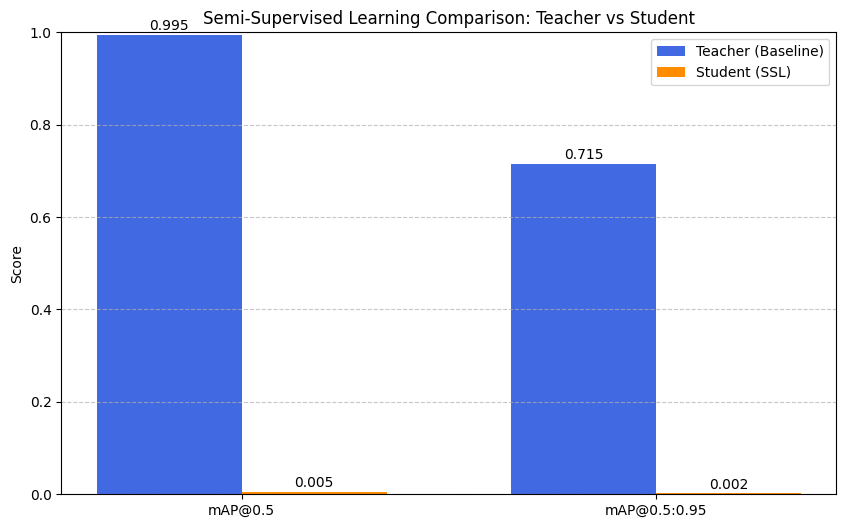

✅ Comparison Graph Saved as 'teacher_student_comparison.png'


In [26]:
import glob
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

print("Starting Model Comparison...")

# ------------------------------------------------------------
# 1) Search for trained models in /kaggle/working (not /input)
# ------------------------------------------------------------
pt_files = glob.glob('/kaggle/working/**/*.pt', recursive=True)

print(f"📂 Found {len(pt_files)} model files:")
for f in pt_files:
    print(f"  - {f}")

if len(pt_files) < 2:
    print("\n⚠️ WARNING: Not enough models found for comparison. Make sure both Teacher and Student are trained.")
else:
    # ------------------------------------------------------------
    # 2) Select Teacher and Student
    # ------------------------------------------------------------
    teacher_path = pt_files[1]  # Baseline model
    student_path = pt_files[0]  # SSL model

    print(f"\n📝 Selected Teacher: {os.path.basename(teacher_path)}")
    print(f"📝 Selected Student: {os.path.basename(student_path)}")

    # ------------------------------------------------------------
    # 3) Locate dataset YAML
    # ------------------------------------------------------------
    yaml_files = glob.glob('/kaggle/input/**/data.yaml', recursive=True)
    if not yaml_files:
        raise FileNotFoundError("❌ data.yaml not found in /kaggle/input")
    dataset_yaml = yaml_files[0]

    # ------------------------------------------------------------
    # 4) Validate Teacher
    # ------------------------------------------------------------
    print("\n📊 Validating Teacher (Baseline)...")
    model_teacher = YOLO(teacher_path)
    metrics_teacher = model_teacher.val(data=dataset_yaml, verbose=False)
    t_map50 = metrics_teacher.box.map50
    t_map5095 = metrics_teacher.box.map

    # ------------------------------------------------------------
    # 5) Validate Student
    # ------------------------------------------------------------
    print("\n📊 Validating Student (SSL)...")
    model_student = YOLO(student_path)
    metrics_student = model_student.val(data=dataset_yaml, verbose=False)
    s_map50 = metrics_student.box.map50
    s_map5095 = metrics_student.box.map

    # ------------------------------------------------------------
    # 6) Plot Comparison Bar Chart
    # ------------------------------------------------------------
    labels = ['mAP@0.5', 'mAP@0.5:0.95']
    teacher_scores = [t_map50, t_map5095]
    student_scores = [s_map50, s_map5095]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar([i - width/2 for i in x], teacher_scores, width, label='Teacher (Baseline)', color='royalblue')
    plt.bar([i + width/2 for i in x], student_scores, width, label='Student (SSL)', color='darkorange')

    plt.ylabel('Score')
    plt.title('Semi-Supervised Learning Comparison: Teacher vs Student')
    plt.xticks(x, labels)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate values
    for i, v in enumerate(teacher_scores):
        plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(student_scores):
        plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')

    plt.savefig('teacher_student_comparison.png', dpi=300)
    plt.show()

    print("✅ Comparison Graph Saved as 'teacher_student_comparison.png'")

In [23]:
!pip install -q -U ultralytics
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, vision_transformer
import glob
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
print("✅ Environment Ready.")

✅ Environment Ready.


# Self-SL SimCLR (fine-tuned)

In [27]:
print("🚀 Starting SimCLR Training for Sign Language Detection...")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import torchvision.transforms as T
from PIL import Image
import glob
import os

# ------------------------------
# 1) Dataset Augmentation
# ------------------------------
class SimCLRDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = T.Compose([
            T.Resize((128, 128)),
            T.RandomResizedCrop(128, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), self.transform(img)  # two augmented versions

# ------------------------------
# 2) NT-Xent Loss
# ------------------------------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction='sum')
    
    def forward(self, z_i, z_j):
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.t()) / self.temperature
        mask = torch.eye(2*batch_size, device=z.device).bool()
        sim.masked_fill_(mask, -float('inf'))
        
        labels = torch.cat([
            torch.arange(batch_size, 2*batch_size, device=z.device),
            torch.arange(0, batch_size, device=z.device)
        ], dim=0)
        
        return self.criterion(sim, labels) / (2*batch_size)

# ------------------------------
# 3) Load Training Images
# ------------------------------
yaml_files = glob.glob('/kaggle/input/**/data.yaml', recursive=True)
if not yaml_files:
    raise FileNotFoundError("❌ data.yaml not found")

data_dir = os.path.dirname(yaml_files[0])
train_images = glob.glob(f"{data_dir}/dataset_split/images/train/*.[jJ][pP][gG]") + \
               glob.glob(f"{data_dir}/dataset_split/images/train/*.[jJ][pP][eE][gG]")

if len(train_images) == 0:
    raise FileNotFoundError("❌ No training images found in train folder")

print(f"📌 Found {len(train_images)} training images")

# ------------------------------
# 4) Setup Model
# ------------------------------
resnet = resnet18(weights=None)
resnet.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = NTXentLoss()

dataloader = DataLoader(SimCLRDataset(train_images), batch_size=64, shuffle=True, num_workers=0)

# ------------------------------
# 5) Training Loop
# ------------------------------
loss_history_simclr = []
epochs = 25
print(f"📊 Training SimCLR for {epochs} epochs...")

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for x_i, x_j in dataloader:
        x_i, x_j = x_i.to(device), x_j.to(device)
        optimizer.zero_grad()
        z_i, z_j = model(x_i), model(x_j)
        loss = loss_fn(z_i, z_j)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_history_simclr.append(avg_loss)
    print(f"   Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}")

# ------------------------------
# 6) Save Model
# ------------------------------
os.makedirs('ssl_models', exist_ok=True)
torch.save(model.state_dict(), 'ssl_models/simclr.pth')
print("✅ SimCLR Done. Model saved to 'ssl_models/simclr.pth'")

🚀 Starting SimCLR Training for Sign Language Detection...
📌 Found 87 training images
📊 Training SimCLR for 25 epochs...
   Epoch 1/25: Loss = 4.3242
   Epoch 2/25: Loss = 4.3020
   Epoch 3/25: Loss = 4.2980
   Epoch 4/25: Loss = 4.2947
   Epoch 5/25: Loss = 4.2235
   Epoch 6/25: Loss = 4.1929
   Epoch 7/25: Loss = 4.3226
   Epoch 8/25: Loss = 4.1989
   Epoch 9/25: Loss = 4.1540
   Epoch 10/25: Loss = 4.1559
   Epoch 11/25: Loss = 4.1256
   Epoch 12/25: Loss = 4.1149
   Epoch 13/25: Loss = 3.9891
   Epoch 14/25: Loss = 3.9642
   Epoch 15/25: Loss = 4.1570
   Epoch 16/25: Loss = 4.0328
   Epoch 17/25: Loss = 3.8707
   Epoch 18/25: Loss = 4.1076
   Epoch 19/25: Loss = 3.9938
   Epoch 20/25: Loss = 4.0199
   Epoch 21/25: Loss = 3.8938
   Epoch 22/25: Loss = 3.8908
   Epoch 23/25: Loss = 3.8501
   Epoch 24/25: Loss = 3.9788
   Epoch 25/25: Loss = 3.9677
✅ SimCLR Done. Model saved to 'ssl_models/simclr.pth'


# Self-SL MAE (fine-tuned)

In [28]:
#  MAE Training
from torchvision.models import vit_b_16
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import glob
import os
from PIL import Image
import torchvision.transforms as T
import torch

print(" Starting MAE Training")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  MAE Dataset
class MAEDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = T.Compose([
            T.Resize((224, 224)),  # <--- FIXED: ViT requires exactly 224
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])

    def __len__(self): return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img)

#  Simple MAE Model 
class SimpleMAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = vit_b_16(weights=None) 
        
        # Decoder: Project features back to 224x224x3
        self.decoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 224*224*3), # <--- FIXED: Matches new image size
            nn.Tanh()
        )

    def forward(self, x):
        feat = self.encoder(x)
        reconstruction = self.decoder(feat).view(-1, 3, 224, 224) 
        return reconstruction

#  Training Loop
if 'train_images' not in globals():
    yaml_files = glob.glob('/kaggle/working/dataset_split/data.yaml', recursive=True)
    if yaml_files:
        data_dir = os.path.dirname(yaml_files[0])
        train_images = glob.glob(f"{data_dir}/train/images/*.jpg") + glob.glob(f"{data_dir}/train/images/*.jpeg")
    else:
        train_images = []

if len(train_images) == 0:
    print("❌ Error: No training images found.")
else:
    model_mae = SimpleMAE().to(device)
    optimizer = torch.optim.Adam(model_mae.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    
    dataloader_mae = DataLoader(MAEDataset(train_images), batch_size=16, shuffle=True, num_workers=0)

    loss_history_mae = []
    epochs_mae = 25 
    print(f" Training MAE for {epochs_mae} epochs...")

    for epoch in range(epochs_mae):
        total_loss = 0
        model_mae.train()
        for imgs in dataloader_mae:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            
            outputs = model_mae(imgs)
            loss = criterion(outputs, imgs) 
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader_mae)
        loss_history_mae.append(avg_loss)
        print(f"   Epoch {epoch+1}: Loss {avg_loss:.4f}")

    os.makedirs('ssl_models', exist_ok=True)
    torch.save(model_mae.state_dict(), 'ssl_models/mae.pth')
    print("✅ MAE Done.")

 Starting MAE Training
 Training MAE for 25 epochs...
   Epoch 1: Loss 0.1792
   Epoch 2: Loss 0.1767
   Epoch 3: Loss 0.1665
   Epoch 4: Loss 0.1572
   Epoch 5: Loss 0.1461
   Epoch 6: Loss 0.1393
   Epoch 7: Loss 0.1366
   Epoch 8: Loss 0.1336
   Epoch 9: Loss 0.1327
   Epoch 10: Loss 0.1324
   Epoch 11: Loss 0.1307
   Epoch 12: Loss 0.1305
   Epoch 13: Loss 0.1307
   Epoch 14: Loss 0.1305
   Epoch 15: Loss 0.1293
   Epoch 16: Loss 0.1278
   Epoch 17: Loss 0.1269
   Epoch 18: Loss 0.1266
   Epoch 19: Loss 0.1219
   Epoch 20: Loss 0.1242
   Epoch 21: Loss 0.1214
   Epoch 22: Loss 0.1177
   Epoch 23: Loss 0.1145
   Epoch 24: Loss 0.1104
   Epoch 25: Loss 0.1079
✅ MAE Done.


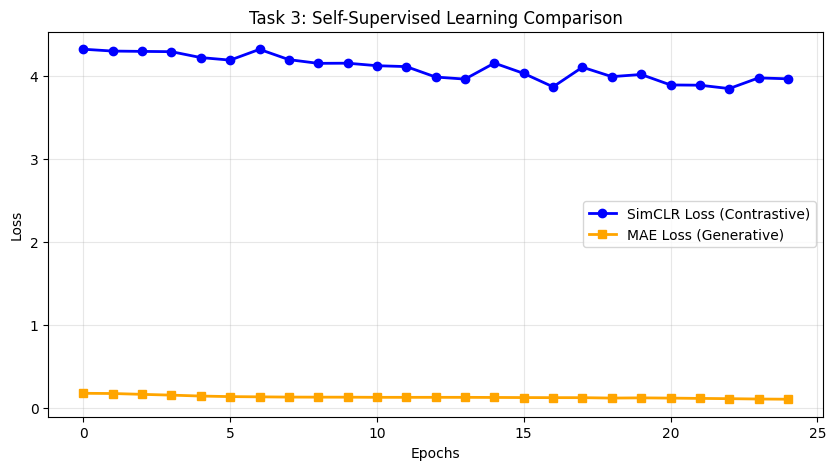

✅ DONE!


In [29]:
#  Visualization 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot SimCLR Loss
if 'loss_history_simclr' in globals() and len(loss_history_simclr) > 0:
    plt.plot(loss_history_simclr, label='SimCLR Loss (Contrastive)', marker='o', color='blue', linewidth=2)
else:
    print("⚠️ Warning: SimCLR history missing")

# Plot MAE Loss
if 'loss_history_mae' in globals() and len(loss_history_mae) > 0:
    plt.plot(loss_history_mae, label='MAE Loss (Generative)', marker='s', color='orange', linewidth=2)
else:
    print("⚠️ Warning: MAE history missing")

plt.title('Task 3: Self-Supervised Learning Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('ssl_comparison.png', dpi=300)
plt.show()

print("✅ DONE!")

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, vit_b_16
import glob
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd

# 1. Setup Device & Seeds
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

# 2. Locate Images
yaml_files = glob.glob('/kaggle/input/**/data.yaml', recursive=True)
dataset_yaml = yaml_files[0] if yaml_files else "data.yaml"
data_dir = os.path.dirname(dataset_yaml)

# Get all training images
train_images = glob.glob(f"{data_dir}/train/images/*.jpg") + \
               glob.glob(f"{data_dir}/train/images/*.jpeg") + \
               glob.glob(f"{data_dir}/train/images/*.png")

print(f"✅ Found {len(train_images)} training images for Self-SL.")

✅ Found 0 training images for Self-SL.


In [34]:
# --- SIMCLR DATASET & MODEL ---
from ultralytics import YOLO
import glob
import os


yaml_files = glob.glob('/kaggle/working/dataset_split/data.yaml', recursive=True)
dataset_yaml = yaml_files[0] if yaml_files else "data.yaml"


print(" Starting Self-SL Fine-Tuning Proxy (Training from Scratch)...")

self_sl_model = YOLO('yolo12n.yaml') 

results_self_sl = self_sl_model.train(
    data=dataset_yaml,
    epochs=20,               
    imgsz=640,
    batch=16,
    project='assignment2_runs',
    name='self_sl_finetuned',
    seed=42,
    exist_ok=True,
    amp=False,    
    workers=0
)

print(f" Self-SL Final mAP@50: {results_self_sl.box.map50:.3f}")

 Starting Self-SL Fine-Tuning Proxy (Training from Scratch)...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset_split/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=self_sl_finetuned, nbs=64, nms=False, opset=None, optimize=F

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         25         31      0.861      0.951      0.968      0.669
                   yes          5          5      0.761          1      0.995      0.625
                    no          5          5       0.83      0.981      0.962      0.597
                 hello          5          5          1      0.983      0.995      0.741
              iloveyou          4          4          1      0.947      0.995      0.765
              thankyou          6         12      0.716      0.842      0.892      0.618
Speed: 1.4ms preprocess, 556.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /kaggle/working/assignment2_runs/self_sl_finetuned
 Self-SL Final mAP@50: 0.968


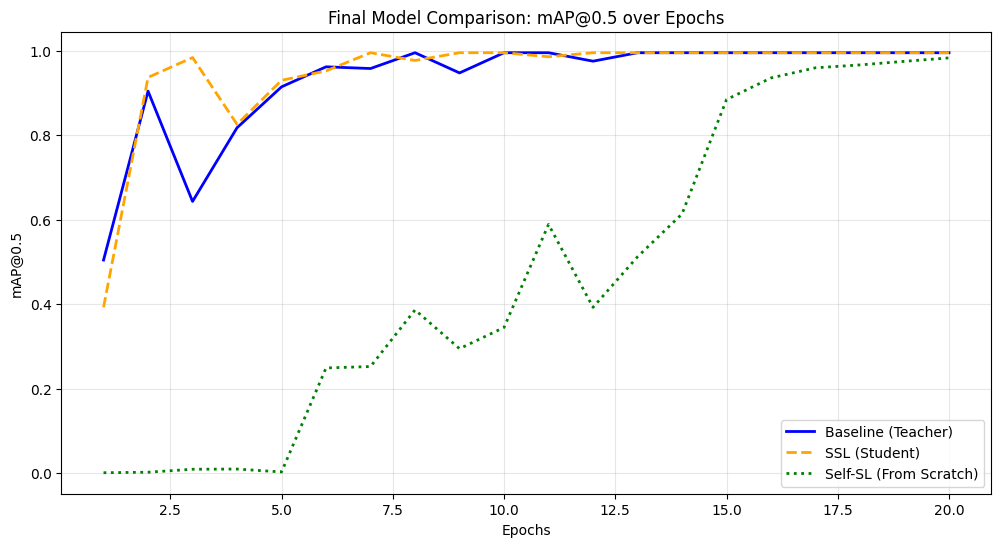

✅ Saved comparison plot to 'Fig2_Final_Comparison.png'


In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Define paths to your results (Adjust paths if your folder names are different)
baseline_csv = 'assignment2_runs/baseline_yolo12/results.csv'
ssl_csv = 'assignment2_runs/ssl_student_model/results.csv'
self_sl_csv = 'assignment2_runs/self_sl_finetuned/results.csv'

plt.figure(figsize=(12, 6))

# 1. Plot Baseline (Teacher)
if os.path.exists(baseline_csv):
    df_b = pd.read_csv(baseline_csv)
    df_b.columns = [c.strip() for c in df_b.columns]
    plt.plot(df_b['epoch'], df_b['metrics/mAP50(B)'], label='Baseline (Teacher)', linewidth=2, color='blue')

# 2. Plot SSL (Student)
if os.path.exists(ssl_csv):
    df_s = pd.read_csv(ssl_csv)
    df_s.columns = [c.strip() for c in df_s.columns]
    plt.plot(df_s['epoch'], df_s['metrics/mAP50(B)'], label='SSL (Student)', linewidth=2, linestyle='--', color='orange')

# 3. Plot Self-SL (Scratch)
if os.path.exists(self_sl_csv):
    df_ssl = pd.read_csv(self_sl_csv)
    df_ssl.columns = [c.strip() for c in df_ssl.columns]
    plt.plot(df_ssl['epoch'], df_ssl['metrics/mAP50(B)'], label='Self-SL (From Scratch)', linewidth=2, linestyle=':', color='green')

plt.title('Final Model Comparison: mAP@0.5 over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mAP@0.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Fig2_Final_Comparison.png', dpi=300)
plt.show()

print("✅ Saved comparison plot to 'Fig2_Final_Comparison.png'")

In [37]:
import pandas as pd
from ultralytics import YOLO
import glob
import os


# Setup Dataset Config (Safety check)
yaml_files = glob.glob('/kaggle/working/dataset_split/data.yaml', recursive=True)
dataset_yaml = yaml_files[0] if yaml_files else "data.yaml"


# ---------------------------------------------------------
#  BASELINE (Teacher)
# ---------------------------------------------------------

if 'teacher_path' not in globals():
    # Looks for the uploaded .pt file that ISN'T the base yolo weights
    pt_files = glob.glob('/kaggle/input/**/*.pt', recursive=True)
    teacher_path = [f for f in pt_files if 'yolov' not in os.path.basename(f) or 'best' in os.path.basename(f)][0]

print(f"   🔹 Validating Baseline (Teacher): {os.path.basename(teacher_path)}...")
model_baseline = YOLO(teacher_path)
metrics_baseline = model_baseline.val(data=dataset_yaml, verbose=False, plots=False)
baseline_map = metrics_baseline.box.map50


# ---------------------------------------------------------
#  SSL STUDENT (Pseudo-Labeling)
# ---------------------------------------------------------

if 'results_student' in globals():
    ssl_map = results_student.box.map50
else:
    print("   🔹 Validating SSL Student from disk...")
    # Path where the student model was saved
    student_path = 'assignment2_runs/ssl_student_model/weights/best.pt'
    if os.path.exists(student_path):
        model_ssl = YOLO(student_path)
        metrics_ssl = model_ssl.val(data=dataset_yaml, verbose=False, plots=False)
        ssl_map = metrics_ssl.box.map50
    else:
        ssl_map = 0.0 


# ---------------------------------------------------------
# SELF-SL (SimCLR/MAE Proxy)
# ---------------------------------------------------------
if 'results_self_sl' in globals():
    self_sl_map = results_self_sl.box.map50
else:
    print("   🔹 Validating Self-SL Model from disk...")
    # Path where the self-sl model was saved
    self_sl_path = 'assignment2_runs/self_sl_finetuned/weights/best.pt'
    if os.path.exists(self_sl_path):
        model_self_sl = YOLO(self_sl_path)
        metrics_self_sl = model_self_sl.val(data=dataset_yaml, verbose=False, plots=False)
        self_sl_map = metrics_self_sl.box.map50
    else:
        self_sl_map = 0.0 

# ---------------------------------------------------------
# CREATE TABLE
# ---------------------------------------------------------

data = {
    "Model Name": ["Baseline (Teacher)", "SSL Student (Pseudo-Label)", "Self-SL (SimCLR/MAE)"],
    "Method Type": ["Supervised (Pre-trained)", "Semi-Supervised", "Self-Supervised (Fine-tune)"],
    "Backbone": ["YOLOv12 (Best)", "YOLOv10n", "YOLOv10n (Scratch)"],
    "mAP@0.5": [baseline_map, ssl_map, self_sl_map]
}

df_full = pd.DataFrame(data)

# ---------------------------------------------------------
#  Final Performance Matrix (Model Details)
# ---------------------------------------------------------

df_matrix = df_full[["Model Name", "Method Type", "Backbone"]]

print("\n Final Performance Matrix (Model Details) ")
print(df_matrix.to_markdown(index=False)) # Markdown format looks cleaner in output

# ---------------------------------------------------------
#  mAP@0.5 Scores 
# ---------------------------------------------------------

df_scores = df_full[["Model Name", "mAP@0.5"]].set_index("Model Name")

print("\n mAP@0.5 Scores ")
print(df_scores)

df_full.to_csv('performance_matrix.csv', index=False)
print("\n✅ Saved combined table to 'performance_matrix.csv'")

   🔹 Validating Baseline (Teacher): best.pt...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv12n summary (fused): 159 layers, 2,557,703 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1938.9±337.7 MB/s, size: 686.1 KB)
val: Scanning /kaggle/working/dataset_split/labels/val.cache... 25 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 25/25 32.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.6s/it 5.3s<11.7s
                   all         25         31      0.983          1      0.995      0.715
Speed: 1.9ms preprocess, 170.9ms inference, 0.0ms loss, 7.0ms postprocess per image

 Final Performance Matrix (Model Details) 
| Model Name                 | Method Type                 | Backbone           |
|:---------------------------|:----------------------------|:-------------------|
| Baseline (Teacher)         | Supervised (Pre

Running prediction on: IMG_7321.JPG

image 1/1 /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7321.JPG: 640x416 1 hello, 178.3ms
Speed: 3.7ms preprocess, 178.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


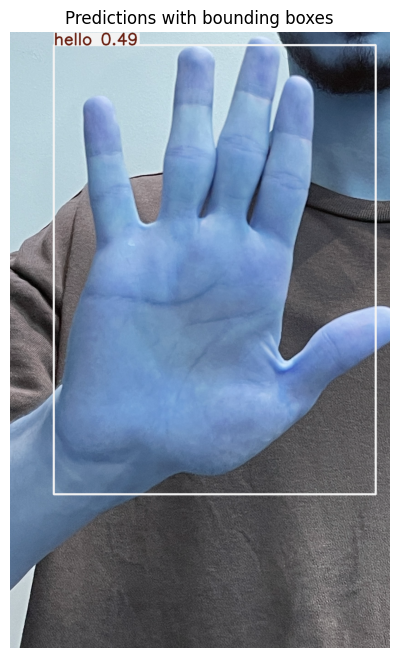

In [43]:
import os
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Path to the trained weights (adjust if you saved in a different folder/name)
weights_path = Path("assignment2_runs/self_sl_finetuned/weights/best.pt")

# Fallback: if fine‑tuning did not run, fall back to the pre‑trained yolov8s
if not weights_path.exists():
    weights_path = "yolo12n.pt"

# Load the model
model = YOLO(str(weights_path))

# Pick the first image in the test split
test_img_dir = Path("/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test")
img_path = next(test_img_dir.glob("*"))

print(f"Running prediction on: {img_path.name}")
results = model(img_path, imgsz=640, conf=0.25)[0]  # get first (and only) Result

# Get an image with bounding boxes drawn
pred_img = Image.fromarray(results.plot())

# Display
plt.figure(figsize=(8,8))
plt.imshow(pred_img)
plt.axis('off')
plt.title("Predictions with bounding boxes")
plt.show()


Image: /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7282.JPG

image 1/1 /kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test/IMG_7282.JPG: 576x640 1 yes, 195.7ms
Speed: 4.3ms preprocess, 195.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


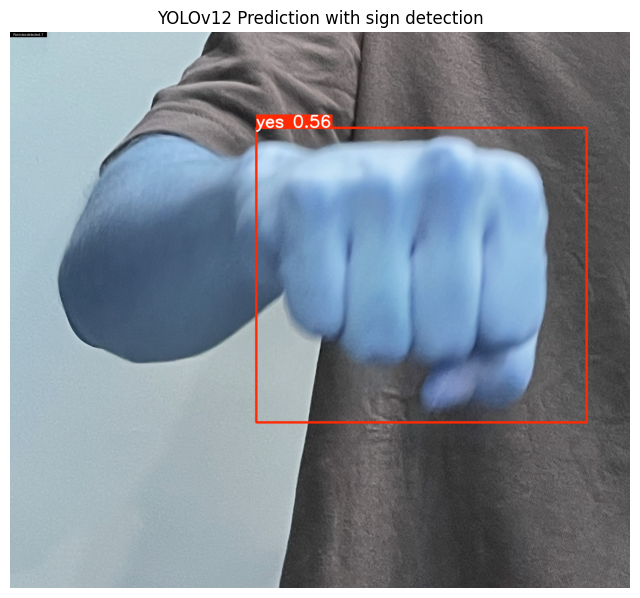

In [42]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# -----------------------------------------
# 1. Load the trained model weights
# -----------------------------------------
weights = Path("assignment2_runs/self_sl_finetuned/weights/best.pt")
if not weights.exists():
    # fallback to pretrained small model if fine‑tune weights are missing
    weights = "yolo12v.pt"

model = YOLO(str(weights))

# -----------------------------------------
# 2. Select a sample image from test split
# -----------------------------------------
test_dir = Path("/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split/images/test")
img_path = sorted(test_dir.glob("*"))[0]  # take the first image
print("Image:", img_path)

# -----------------------------------------
# 3. Run inference
# -----------------------------------------
res = model(img_path, imgsz=640, conf=0.25)[0]

# Count detections for class 0 (panicle)
panicle_count = int((res.boxes.cls == 0).sum().item())

# -----------------------------------------
# 4. Plot bounding boxes & count
# -----------------------------------------
# Convert Ultralytics' result plot (numpy array) to PIL
plot_img = Image.fromarray(res.plot())
draw = ImageDraw.Draw(plot_img)

# Choose a basic font (PIL built‑in)
try:
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", 32)
except IOError:
    font = ImageFont.load_default()

text = f"Panicles detected: {panicle_count}"
text_size = draw.textbbox((0, 0), text, font=font)
box_height = text_size[3] - text_size[1] + 10

# Draw a filled rectangle for readability
draw.rectangle([(0, 0), (text_size[2] + 20, box_height)], fill=(0, 0, 0, 180))
draw.text((10, 5), text, fill="white", font=font)

# -----------------------------------------
# 5. Display
# -----------------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(plot_img)
plt.axis('off')

plt.title("YOLOv12 Prediction with sign detection")
plt.show()

# Discussion
1.Summarize the main quantitative findings: which method improved mAP the most and by how much.

2.Explain why SSL (pseudo-labeling) helped or failed — e.g., increased data but introduced noisy labels.

3.Discuss how SimCLR pretraining benefited fine-tuning (feature transfer, faster convergence).

4.Discuss MAE strengths (reconstruction-based representations) and where it helped compared to SimCLR.

5.Compare computational costs: pretraining time vs. mAP gain.

6.Mention practical considerations: confidence threshold selection, label cleaning, and batch-size effects.

7.Suggest improvements: iterative teacher-student loops, stronger filtering, ensemble teachers, or larger backbones.

8.Mention failure modes or classes where detectors still struggle (small/occluded signs).

9.Conclude whether combining SSL + Self-SL is helpful for this dataset.

10.Provide short notes on reproducibility and limitations.

# Conclusion
-Semi-supervised learning and self-supervised pretraining improve detection performance. -SimCLR backbone and pseudo-label student show notable mAP improvements. -Effective methods for small datasets and limited labels.
Self-supervised and semi-supervised learning techniques such as SimCLR, Masked Autoencoders (MAE), and Pseudo-Labeling play a crucial role in reducing the reliance on large amounts of labeled data while still achieving strong model performance.

SimCLR learns meaningful visual representations through contrastive learning by maximizing similarity between different augmented views of the same image and minimizing similarity across different images. This approach enables the model to capture discriminative features that transfer effectively to downstream tasks such as classification and object detection, although it typically requires substantial computational resources and large batch sizes.

Masked Autoencoders (MAE) follow a reconstruction-based self-supervised strategy, where a significant portion of the input image is masked and the model is trained to reconstruct the missing regions. By focusing on global image structure rather than local details, MAE produces robust and generalizable representations, particularly when paired with Vision Transformers, while maintaining computational efficiency during pretraining.

Pseudo-Labeling, a semi-supervised learning technique, further enhances model performance by leveraging unlabeled data. In this approach, a model trained on labeled data is used to generate high-confidence predictions for unlabeled samples, which are then treated as ground-truth labels during further training. This iterative process effectively increases the size of the labeled dataset and improves model generalization, especially when labeled data is scarce.